In [3]:
%matplotlib inline

from __future__ import division
import numpy as np
import menpo.io as mio
from menpo.image import Image
from menpo.feature import greyscale, normalize_norm, normalize_std, fast_dsift
from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images, print_dynamic, progress_bar_str
from menpofit.visualize import visualize_fitting_results
from alaborticcv2015.alignment import LKFitter, FilteredSSD, FilteredFourierSSD

# Multipie experiment: PCA Net

In [4]:
folder_path = '/data/PhD/alaborticcv2015/'

In [5]:
images = []
for i in mio.import_images(folder_path + 'data/multipie/**/*', verbose=True):
    i.crop_to_landmarks_proportion_inplace(0.5)
    i = i.rescale_landmarks_to_diagonal_range(200)
    labeller(i, 'PTS', ibug_face_66)
    lms = i.landmarks['ibug_face_66'].lms
    bb = lms.bounding_box()
    i.landmarks['bounding_box'] = bb
    images.append(i)

- Loading 100 assets: [====================] 100%

In [6]:
n_subjects = 5
n_images_subject = 20

subjects = []
for j in range(n_subjects):
    subject = {'template':images[j*n_images_subject+7],
               'test_images':images[j*n_images_subject:j*n_images_subject+n_images_subject]}
    subjects.append(subject)

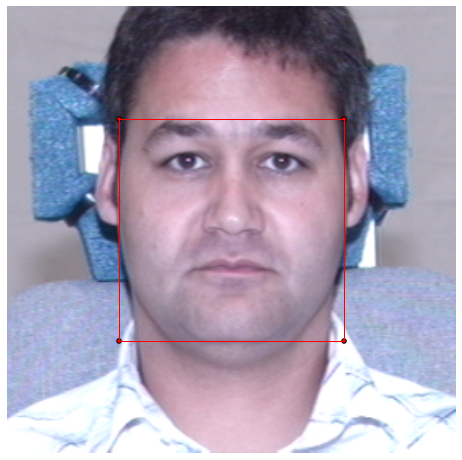

In [7]:
templates = [subject['template'] for subject in subjects]
visualize_images(templates)

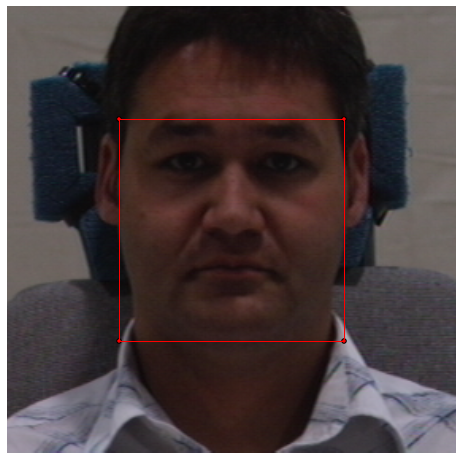

In [8]:
test_images = []
for subject in subjects:
    test_images += subject['test_images']
visualize_images(test_images)

In [9]:
features = greyscale
diagonal = 100
scales = (1,)
max_iters = 50
noise_std = 10
n_rep = 10

nf = 16
ps = 5

# PCA Deep Convolutional Kernel 

In [10]:
results = []
errors = np.empty((n_subjects, n_images_subject, n_rep, max_iters+len(scales)))

# for all subjects
for sub, subject in enumerate(subjects):
    
    template = subject['template']
    test_images = subject['test_images']
        
    string = '- network {}, {}, subject {}: '.format(nf, ps, sub)

    # load network
    file_name = (folder_path
                 + 'networks/pca_net/pca_net_1_1_' 
                 + str(nf) 
                 + '_' 
                 + str(ps)
                 + '.pkl.gz') 
    net = mio.import_pickle(file_name)

    # define kernel function
    def kernel_func(ext_shape):
        return net._compute_kernel(ext_shape=ext_shape)

    # create LK fitter
    fitter = LKFitter(template,
                      group='bounding_box',
                      features=features,
                      diagonal=diagonal,
                      scales=scales,
                      residual_cls=FilteredFourierSSD,
                      kernel_func=kernel_func,
                      eps=-1)

    # random seed
    np.random.seed(seed=0)

    # for all images
    fitter_results = []
    for j, i in enumerate(test_images):
        string2 = string + ' image {}: '.format(j)

        # for each repetition
        frs = []
        for k in range(n_rep):

            # fit image
            gt_s = i.landmarks['bounding_box'].lms
            s = fitter.perturb_shape(gt_s, noise_std=noise_std)
            fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=max_iters)

            # save fitter result
            fr = fr.as_serializableresult()
            frs.append(fr)

            # compute error
            errors[sub, j, k] = fr.errors() 

        # save each repetition fitting result
        fitter_results.append(frs)

        # compute and print errors statistics per image
        ini_errors = errors[sub, j, :, 0]
        ini_mean = np.mean(ini_errors)
        ini_median = np.median(ini_errors)
        ini_std = np.std(ini_errors)
        final_errors = errors[sub, j, :, -1]
        final_mean = np.mean(final_errors)
        final_median = np.median(final_errors)
        final_std = np.std(final_errors)
        print_dynamic(string2 + 
                      '\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                      ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                      ' std: {0:.4f} - {1:.4f} '.format(ini_std, final_std))

    # compute and print error statistics per network
    ini_errors = errors[sub, :, :, 0]
    ini_mean = np.mean(ini_errors)
    ini_median = np.median(ini_errors)
    ini_std = np.std(ini_errors)
    final_errors = errors[sub, :, :, -1]
    final_mean = np.mean(final_errors)
    final_median = np.median(final_errors)
    final_std = np.std(final_errors)
    print_dynamic(string + 
                  '\t\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                  ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                  ' std: {0:.4f} - {1:.4f} \n'.format(ini_std, final_std))

    # save each image fitting result
    results.append(fitter_results)
    
# save network fitting results
file_name = (folder_path
             + 'results/multipie/multipie_pcadck_1_1_' 
             + str(nf) 
             + '_' 
             + str(ps)
             + '_'
             + str(noise_std)
             + '.pkl.gz') 
mio.export_pickle(results, file_name, overwrite=True)

- network 16, 5, subject 0: 		mean: 0.0758 - 0.0324  median: 0.0739 - 0.0094  std: 0.0223 - 0.0474 
- network 16, 5, subject 1: 		mean: 0.0758 - 0.0308  median: 0.0739 - 0.0096  std: 0.0223 - 0.0430 
- network 16, 5, subject 2: 		mean: 0.0758 - 0.0328  median: 0.0739 - 0.0104  std: 0.0223 - 0.0502 
- network 16, 5, subject 3: 		mean: 0.0758 - 0.0359  median: 0.0739 - 0.0155  std: 0.0224 - 0.0417 
- network 16, 5, subject 4: 		mean: 0.0759 - 0.0399  median: 0.0740 - 0.0162  std: 0.0224 - 0.0430 


/data/pythondev/src/menpo/menpo/image/base.py:130: UserWarning: The copy flag was NOT honoured. A copy HAS been made. Please ensure the data you pass is C-contiguous.
  warn('The copy flag was NOT honoured. A copy HAS been made. '


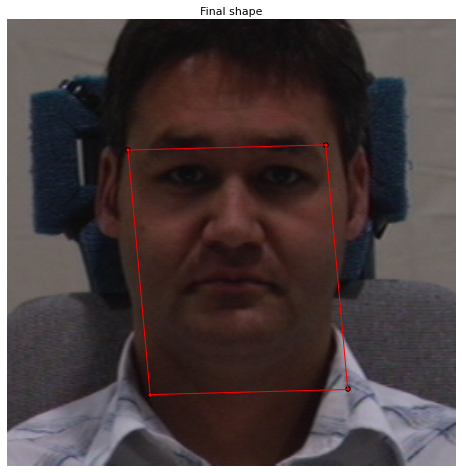

In [11]:
# undo list nesting
fitter_results = [fr for fitting_results in results for frs in fitting_results for fr in frs]

# visualize
visualize_fitting_results(fitter_results)

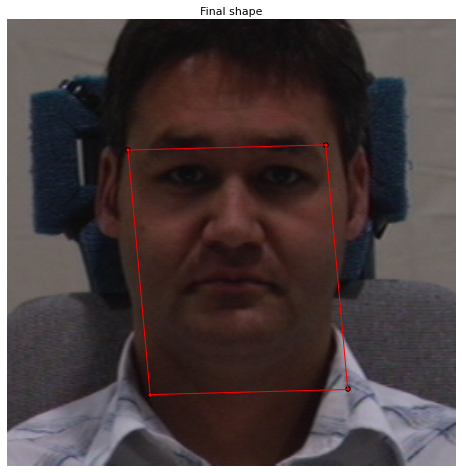

In [12]:
# undo list nesting
fitter_results = [fr for fitting_results in results for frs in fitting_results for fr in frs]

# visualize
visualize_fitting_results(fitter_results)

# PCA Deep Convolutional Kernel features 

In [13]:
results = []
errors = np.empty((n_subjects, n_images_subject, n_rep, max_iters+len(scales)))

# for all subjects
for sub, subject in enumerate(subjects):
    
    template = subject['template']
    test_images = subject['test_images']
        
    string = '- network {}, {}, subject {}: '.format(nf, ps, sub)

    # load network
    file_name = (folder_path
                 + 'networks/pca_net/pca_net_1_1_' 
                 + str(nf) 
                 + '_' 
                 + str(ps)
                 + '.pkl.gz') 
    net = mio.import_pickle(file_name)

    # create LK fitter
    fitter = LKFitter(template,
                      group='bounding_box',
                      features=net.kernel_response,
                      diagonal=diagonal,
                      scales=scales,
                      residual_cls=FilteredSSD,
                      eps=-1)

    # random seed
    np.random.seed(seed=0)

    # for all images
    fitter_results = []
    for j, i in enumerate(test_images):
        string2 = string + ' image {}: '.format(j)

        # for each repetition
        frs = []
        for k in range(n_rep):

            # fit image
            gt_s = i.landmarks['bounding_box'].lms
            s = fitter.perturb_shape(gt_s, noise_std=noise_std)
            fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=max_iters)

            # save fitter result
            fr = fr.as_serializableresult()
            frs.append(fr)

            # compute error
            errors[sub, j, k] = fr.errors() 

        # save each repetition fitting result
        fitter_results.append(frs)

        # compute and print errors statistics per image
        ini_errors = errors[sub, j, :, 0]
        ini_mean = np.mean(ini_errors)
        ini_median = np.median(ini_errors)
        ini_std = np.std(ini_errors)
        final_errors = errors[sub, j, :, -1]
        final_mean = np.mean(final_errors)
        final_median = np.median(final_errors)
        final_std = np.std(final_errors)
        print_dynamic(string2 + 
                      '\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                      ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                      ' std: {0:.4f} - {1:.4f} '.format(ini_std, final_std))

    # compute and print error statistics per network
    ini_errors = errors[sub, :, :, 0]
    ini_mean = np.mean(ini_errors)
    ini_median = np.median(ini_errors)
    ini_std = np.std(ini_errors)
    final_errors = errors[sub, :, :, -1]
    final_mean = np.mean(final_errors)
    final_median = np.median(final_errors)
    final_std = np.std(final_errors)
    print_dynamic(string + 
                  '\t\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                  ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                  ' std: {0:.4f} - {1:.4f} \n'.format(ini_std, final_std))

    # save each image fitting result
    results.append(fitter_results)
    
# save network fitting results
file_name = (folder_path
             + 'results/multipie/multipie_pcadck_features_1_1_' 
             + str(nf) 
             + '_' 
             + str(ps)
             + '_'
             + str(noise_std)
             + '.pkl.gz') 
mio.export_pickle(results, file_name, overwrite=True)

- network 16, 5, subject 0: 		mean: 0.0758 - 0.0386  median: 0.0739 - 0.0104  std: 0.0223 - 0.0501 
- network 16, 5, subject 1: 		mean: 0.0758 - 0.0314  median: 0.0739 - 0.0092  std: 0.0223 - 0.0426 
- network 16, 5, subject 2: 		mean: 0.0758 - 0.0341  median: 0.0739 - 0.0097  std: 0.0223 - 0.0513 
- network 16, 5, subject 3: 		mean: 0.0758 - 0.0434  median: 0.0739 - 0.0157  std: 0.0224 - 0.0495 
- network 16, 5, subject 4: 		mean: 0.0759 - 0.0521  median: 0.0740 - 0.0178  std: 0.0224 - 0.0558 


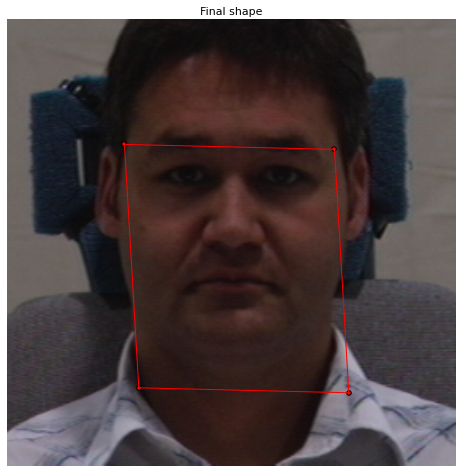

In [14]:
# undo list nesting
fitter_results = [fr for fitting_results in results for frs in fitting_results for fr in frs]

# visualize
visualize_fitting_results(fitter_results)

# PCA Net features

In [15]:
results = []
errors = np.empty((n_subjects, n_images_subject, n_rep, max_iters+len(scales)))

# for all subjects
for sub, subject in enumerate(subjects):
    
    template = subject['template']
    test_images = subject['test_images']
        
    string = '- network {}, {}, subject {}: '.format(nf, ps, sub)

    # load network
    file_name = (folder_path
                 + 'networks/pca_net/pca_net_1_1_' 
                 + str(nf) 
                 + '_' 
                 + str(ps)
                 + '.pkl.gz') 
    net = mio.import_pickle(file_name)

    # create LK fitter
    fitter = LKFitter(template,
                      group='bounding_box',
                      features=net.network_response,
                      diagonal=diagonal,
                      scales=scales,
                      residual_cls=FilteredSSD,
                      eps=-1)

    # random seed
    np.random.seed(seed=0)

    # for all images
    fitter_results = []
    for j, i in enumerate(test_images):
        string2 = string + ' image {}: '.format(j)

        # for each repetition
        frs = []
        for k in range(n_rep):

            # fit image
            gt_s = i.landmarks['bounding_box'].lms
            s = fitter.perturb_shape(gt_s, noise_std=noise_std)
            fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=max_iters)

            # save fitter result
            fr = fr.as_serializableresult()
            frs.append(fr)

            # compute error
            errors[sub, j, k] = fr.errors() 

        # save each repetition fitting result
        fitter_results.append(frs)

        # compute and print errors statistics per image
        ini_errors = errors[sub, j, :, 0]
        ini_mean = np.mean(ini_errors)
        ini_median = np.median(ini_errors)
        ini_std = np.std(ini_errors)
        final_errors = errors[sub, j, :, -1]
        final_mean = np.mean(final_errors)
        final_median = np.median(final_errors)
        final_std = np.std(final_errors)
        print_dynamic(string2 + 
                      '\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                      ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                      ' std: {0:.4f} - {1:.4f} '.format(ini_std, final_std))

    # compute and print error statistics per network
    ini_errors = errors[sub, :, :, 0]
    ini_mean = np.mean(ini_errors)
    ini_median = np.median(ini_errors)
    ini_std = np.std(ini_errors)
    final_errors = errors[sub, :, :, -1]
    final_mean = np.mean(final_errors)
    final_median = np.median(final_errors)
    final_std = np.std(final_errors)
    print_dynamic(string + 
                  '\t\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                  ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                  ' std: {0:.4f} - {1:.4f} \n'.format(ini_std, final_std))

    # save each image fitting result
    results.append(fitter_results)
    
# save network fitting results
file_name = (folder_path
             + 'results/multipie/multipie_pcanet_features_1_1_' 
             + str(nf) 
             + '_' 
             + str(ps)
             + '_'
             + str(noise_std)
             + '.pkl.gz') 
mio.export_pickle(results, file_name, overwrite=True)

- network 16, 5, subject 0: 		mean: 0.0758 - 0.0343  median: 0.0739 - 0.0090  std: 0.0223 - 0.0456 
- network 16, 5, subject 1: 		mean: 0.0758 - 0.0316  median: 0.0739 - 0.0095  std: 0.0223 - 0.0385 
- network 16, 5, subject 2: 		mean: 0.0758 - 0.0344  median: 0.0739 - 0.0118  std: 0.0223 - 0.0484 
- network 16, 5, subject 3: 		mean: 0.0758 - 0.0360  median: 0.0739 - 0.0149  std: 0.0224 - 0.0400 
- network 16, 5, subject 4: 		mean: 0.0759 - 0.0372  median: 0.0740 - 0.0138  std: 0.0224 - 0.0392 


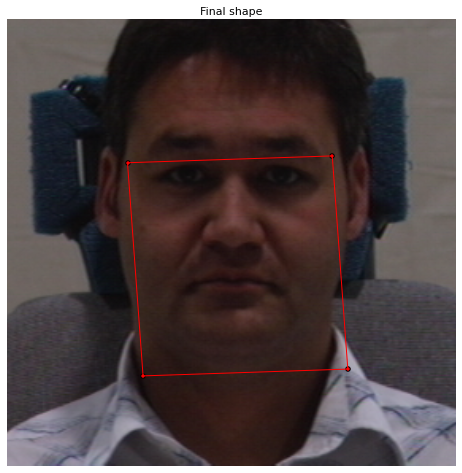

In [16]:
# undo list nesting
fitter_results = [fr for fitting_results in results for frs in fitting_results for fr in frs]

# visualize
visualize_fitting_results(fitter_results)